In [1]:
# Step 1: Install Dependencies
!pip install -U torch torchvision torchaudio
!pip install -U opencv-python-headless
!pip install -U git+https://github.com/facebookresearch/fvcore.git
!pip install -U git+https://github.com/facebookresearch/detectron2.git
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import torch
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [2]:
# Mount Google Drive to access your BoneFractureDetection folder
from google.colab import drive
drive.mount('/content/drive')

# Set base path for your dataset inside Drive
base_path = "/content/drive/MyDrive/BoneFractureDetection"

Mounted at /content/drive


# Bone Fracture Detection with Detectron2 (Faster R-CNN)
This notebook runs Faster R-CNN using Detectron2 on resized COCO-formatted fracture data.

In [3]:
import os
import torch
import cv2
import random
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
# === Step 1: Set paths === #
base_path = "/content/drive/MyDrive/BoneFractureDetection"
train_json = os.path.join(base_path, "processed_data/annotations_remapped/train_resized_remapped.json")
valid_json = os.path.join(base_path, "processed_data/annotations_remapped/valid_resized_remapped.json")
image_dir = os.path.join(base_path, "processed_data/images")

In [5]:
# === Step 2: Register datasets === #
register_coco_instances("fracture_train", {}, train_json, image_dir)
register_coco_instances("fracture_val", {}, valid_json, image_dir)

metadata = MetadataCatalog.get("fracture_train")

In [6]:
from detectron2.model_zoo import get_config_file

# === Step 3: Create config for Faster R-CNN === #
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("fracture_train",)
cfg.DATASETS.TEST = ("fracture_val",)
cfg.DATALOADER.NUM_WORKERS = 2

from detectron2.model_zoo import get_checkpoint_url
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

cfg.OUTPUT_DIR = os.path.join(base_path, "output_detectron2")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [7]:
# import json
# import os

# # Path to your annotation file (train or valid)
# annotation_path = "/Users/raveenasiva/Downloads/BoneFractureDetection/processed_data/annotations/train_resized.json"

# # Load annotation data
# with open(annotation_path, 'r') as f:
#     coco_data = json.load(f)

# # Print declared categories
# print("Categories declared in 'categories':")
# for cat in coco_data["categories"]:
#     print(f"  id: {cat['id']}, name: {cat['name']}")

# # Check category_ids used in annotations
# category_ids = [ann["category_id"] for ann in coco_data["annotations"]]
# unique_ids = sorted(set(category_ids))

# print("\n🔍 Unique category_ids used in annotations:")
# print(unique_ids)

# print(f"\n Number of classes used in annotations: {len(unique_ids)}")

In [8]:
# import json
# import os

# # Input and output paths
# in_paths = [
#     "/Users/raveenasiva/Downloads/BoneFractureDetection/processed_data/annotations/train_resized.json",
#     "/Users/raveenasiva/Downloads/BoneFractureDetection/processed_data/annotations/valid_resized.json"
# ]

# out_dir = "/Users/raveenasiva/Downloads/BoneFractureDetection/processed_data/annotations_remapped"
# os.makedirs(out_dir, exist_ok=True)

# # Remapping dictionary
# remap_ids = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

# # New categories list
# new_categories = [
#     {"id": 0, "name": "elbow positive"},
#     {"id": 1, "name": "fingers positive"},
#     {"id": 2, "name": "forearm fracture"},
#     {"id": 3, "name": "humerus"},
#     {"id": 4, "name": "humerus fracture"},
#     {"id": 5, "name": "shoulder fracture"},
#     {"id": 6, "name": "wrist positive"}
# ]

# for path in in_paths:
#     with open(path, "r") as f:
#         coco = json.load(f)

#     # Update annotations
#     for ann in coco["annotations"]:
#         if ann["category_id"] in remap_ids:
#             ann["category_id"] = remap_ids[ann["category_id"]]

#     # Replace categories
#     coco["categories"] = new_categories

#     # Write to new file
#     filename = os.path.basename(path).replace(".json", "_remapped.json")
#     out_path = os.path.join(out_dir, filename)
#     with open(out_path, "w") as f:
#         json.dump(coco, f)

#     print(f"Saved remapped annotations to: {out_path}")


In [9]:
# === Step 4: Train === #
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/12 17:19:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 93.9MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/12 17:19:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/12 17:19:36 d2.utils.events]:  eta: 0:21:22  iter: 19  total_loss: 2.39  loss_cls: 2.127  loss_box_reg: 0.05052  loss_rpn_cls: 0.1209  loss_rpn_loc: 0.01395    time: 0.4417  last_time: 0.5398  data_time: 0.7374  last_data_time: 0.2316   lr: 4.9953e-06  max_mem: 1735M
[04/12 17:19:52 d2.utils.events]:  eta: 0:20:46  iter: 39  total_loss: 2.19  loss_cls: 1.902  loss_box_reg: 0.1104  loss_rpn_cls: 0.1258  loss_rpn_loc: 0.01166    time: 0.4272  last_time: 0.4451  data_time: 0.1390  last_data_time: 0.2003   lr: 9.9902e-06  max_mem: 1735M
[04/12 17:20:01 d2.utils.events]:  eta: 0:20:17  iter: 59  total_loss: 1.718  loss_cls: 1.463  loss_box_reg: 0.06597  loss_rpn_cls: 0.1962  loss_rpn_loc: 0.01561    time: 0.4265  last_time: 0.4006  data_time: 0.1505  last_data_time: 0.1311   lr: 1.4985e-05  max_mem: 1736M
[04/12 17:20:09 d2.utils.events]:  eta: 0:20:17  iter: 79  total_loss: 1.136  loss_cls: 0.8776  loss_box_reg: 0.07326  loss_rpn_cls: 0.1384  loss_rpn_loc: 0.0111    time: 0.4254  last_

In [10]:
# === Step 5: Evaluate === #
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("fracture_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "fracture_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[04/12 17:36:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/BoneFractureDetection/output_detectron2/model_final.pth ...
WARNING [04/12 17:36:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 17:36:35 d2.data.datasets.coco]: Loaded 727 images in COCO format from /content/drive/MyDrive/BoneFractureDetection/processed_data/annotations_remapped/valid_resized_remapped.json
[04/12 17:36:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/12 17:36:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/12 17:36:35 d2.data.common]: Serializing 727 elements to byte tensors and concatenating them all ...
[04/12 17:36:35 d2.data.common]: Serialized dataset takes 0.23 MiB
[04/12 17:36:35 d2.evaluation.eva

WARNING [04/12 17:39:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 17:39:16 d2.data.datasets.coco]: Loaded 727 images in COCO format from /content/drive/MyDrive/BoneFractureDetection/processed_data/annotations_remapped/valid_resized_remapped.json


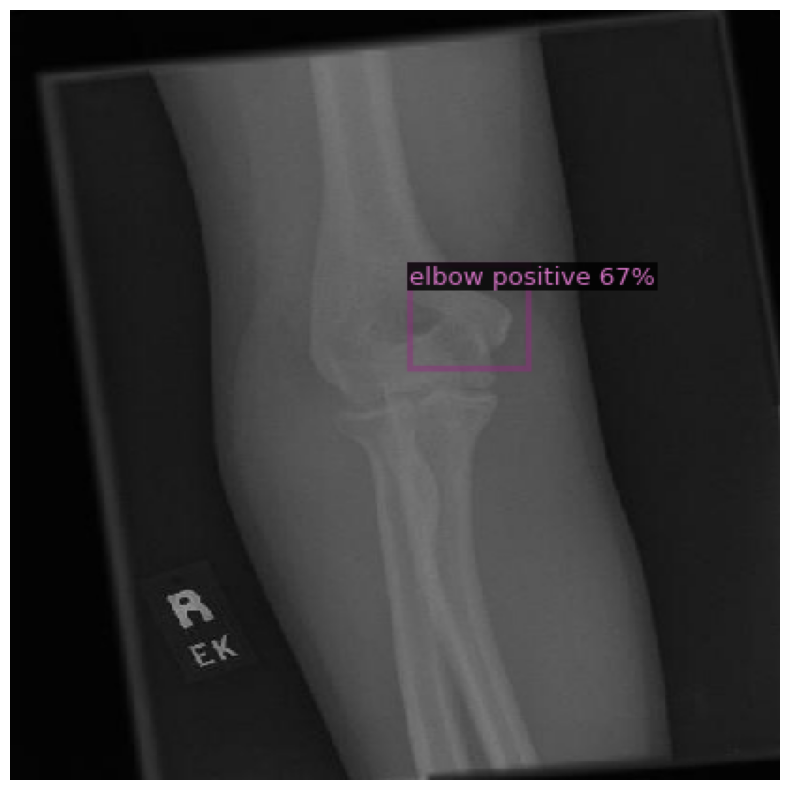

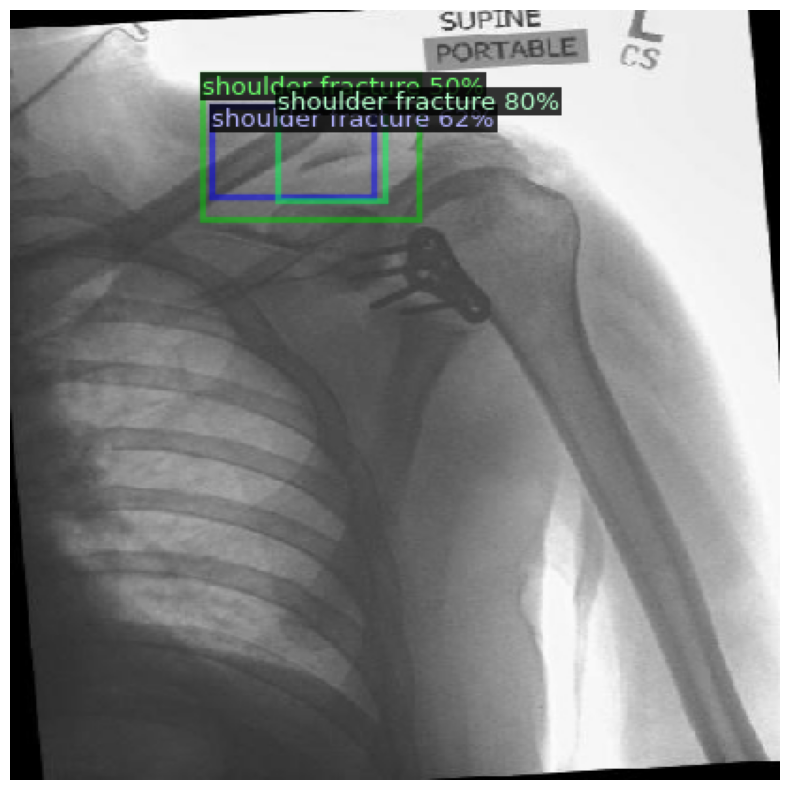

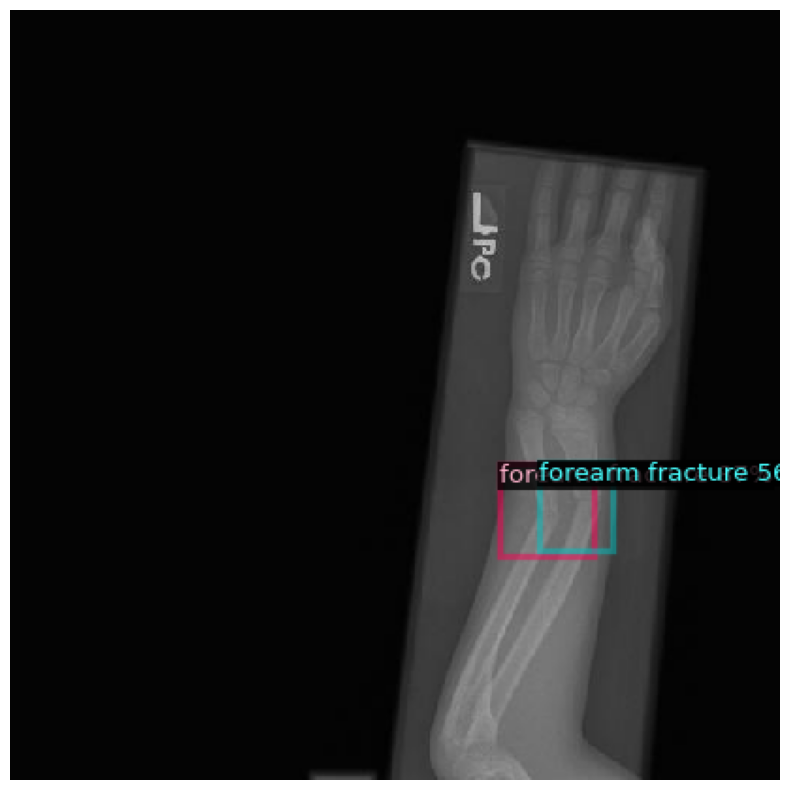

In [11]:
# === Step 6: Visualize predictions === #
from matplotlib import pyplot as plt

dataset_dicts = DatasetCatalog.get("fracture_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

[04/12 17:56:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/BoneFractureDetection/output_detectron2/model_final.pth ...
Found 169 test images.
Fracture detected in: image1_3565_png.rf.52153ba946f07810b3c16f62d202db16.jpg


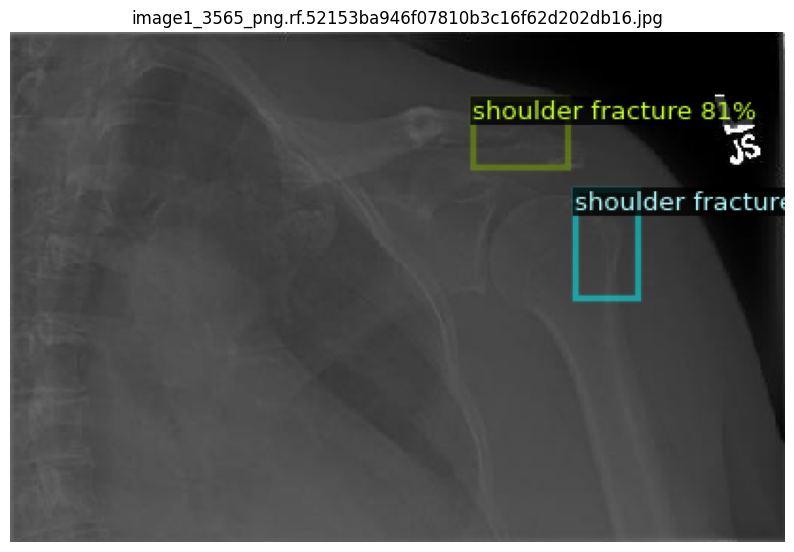

Fracture detected in: image1_4966_png.rf.27ae131adff1063f606ceecb0fddc7c2.jpg


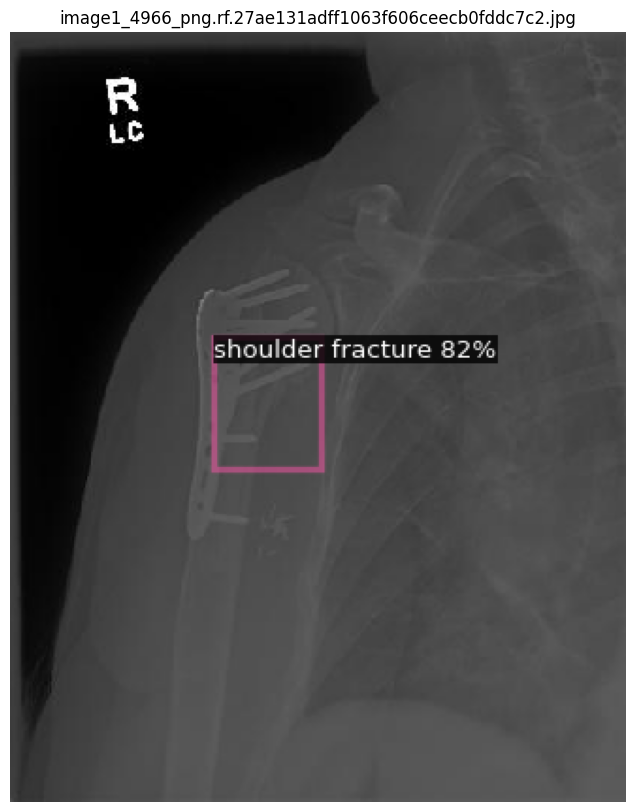

Fracture detected in: image2_698_png.rf.66b6d614653eed2ef4e81695aca5c5a6.jpg


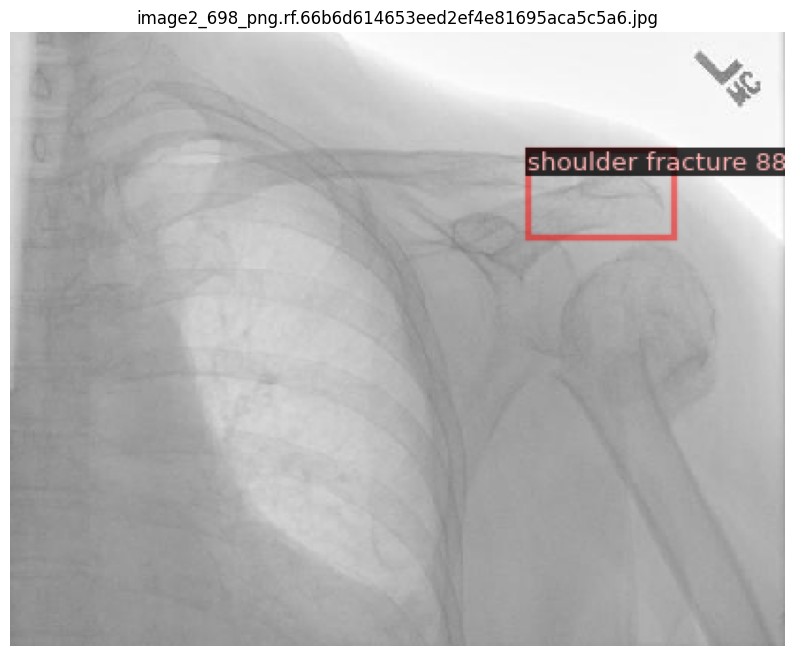

Fracture detected in: image1_8002_png.rf.3b1d55e198fdcd09f808da01429ee7c7.jpg


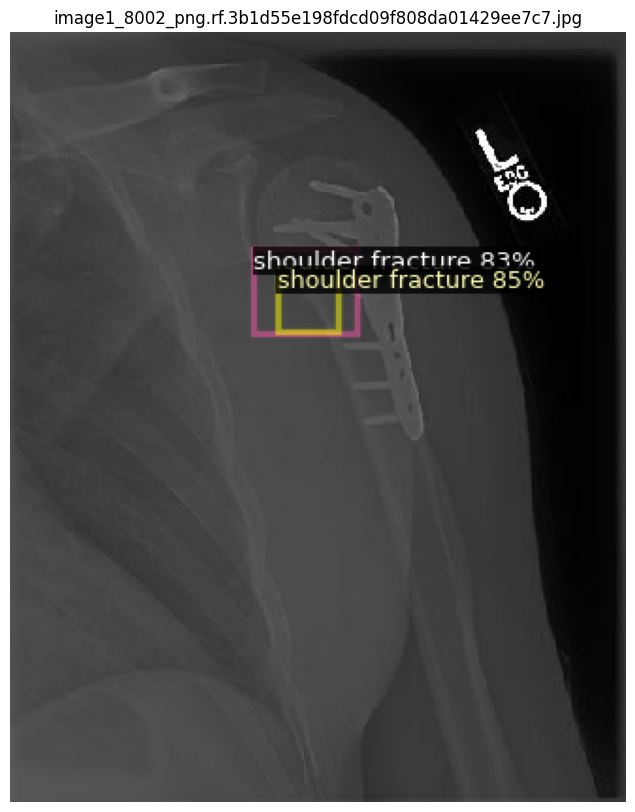

In [43]:
import os
import cv2
import random
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Set lower confidence threshold and re-initialize predictor
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

# Path to test images
test_dir = "/content/drive/MyDrive/BoneFractureDetection/test_images"
test_imgs = [f for f in os.listdir(test_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random.shuffle(test_imgs)
print(f"Found {len(test_imgs)} test images.")

# Collect 4 valid predictions
shown = 0
for img_name in test_imgs:
    path = os.path.join(test_dir, img_name)
    img = cv2.imread(path)

    outputs = predictor(img)

    if len(outputs["instances"]) == 0:
        continue

    print(f"Fracture detected in: {img_name}")
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("fracture_train"), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(img_name)
    plt.axis("off")
    plt.show()

    shown += 1
    if shown == 4:
        break

Found 169 test images.
Fracture class 1 detected in: image1_1044_png.rf.1e17d3a8637036ef4b3e1c5d0b88011f.jpg


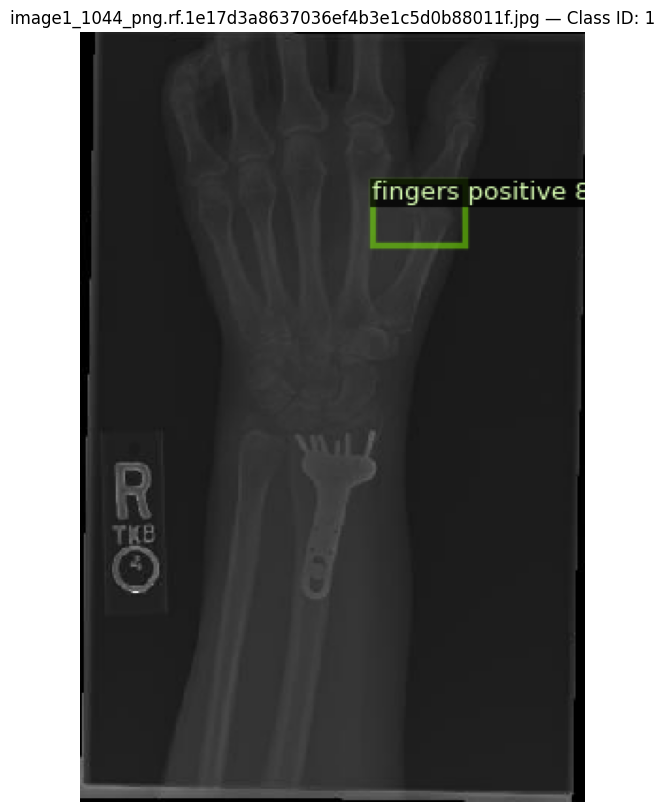

Fracture class 5 detected in: image1_2128_png.rf.9cdb5d69b7f964d77ef2cd8ddaa64b3d.jpg


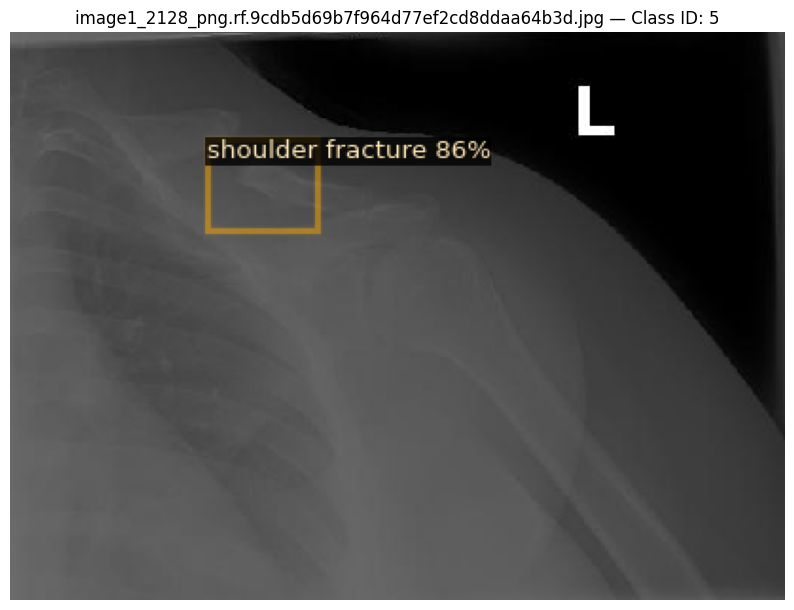

Fracture class 2 detected in: image1_1126_png.rf.66c21ce21ee255ed4bdc66164bac87c5.jpg


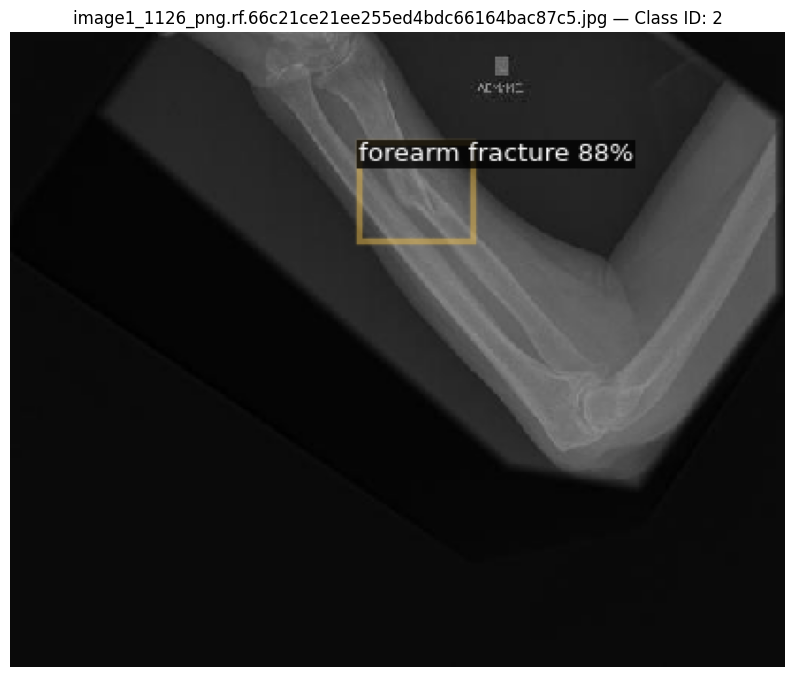

In [44]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

test_dir = "/content/drive/MyDrive/BoneFractureDetection/test_images"
test_imgs = [f for f in os.listdir(test_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random.shuffle(test_imgs)
print(f"Found {len(test_imgs)} test images.")

# Track shown classes
shown_classes = set()
max_classes_to_show = 4

for img_name in test_imgs:
    path = os.path.join(test_dir, img_name)
    img = cv2.imread(path)

    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    if len(instances) == 0:
        continue

    pred_classes = instances.pred_classes.numpy().tolist()

    # Check if we found a class not shown yet
    for cls in pred_classes:
        if cls not in shown_classes:
            shown_classes.add(cls)

            print(f"Fracture class {cls} detected in: {img_name}")
            v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("fracture_train"), scale=0.8)
            out = v.draw_instance_predictions(instances)

            plt.figure(figsize=(10, 10))
            plt.imshow(out.get_image()[:, :, ::-1])
            plt.title(f"{img_name} — Class ID: {cls}")
            plt.axis("off")
            plt.show()
            break  # Move to next image

    if len(shown_classes) >= max_classes_to_show:
        break

## Loss Curve Plot

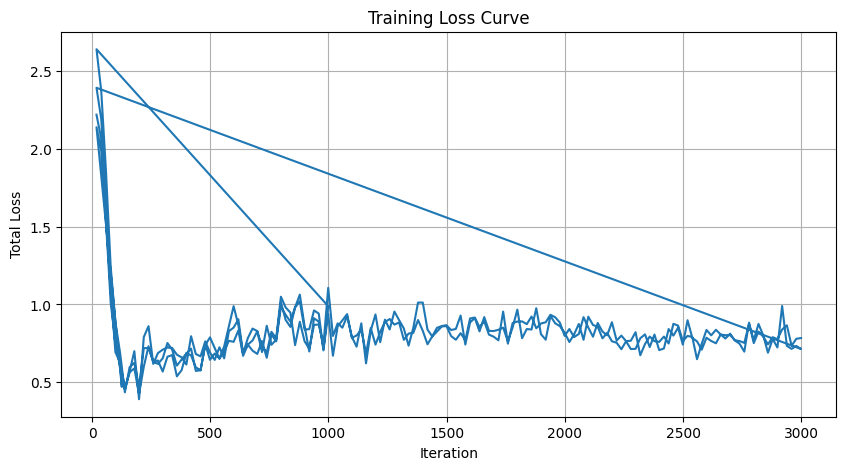

In [13]:
# Detectron2 logs training metrics to events file. We'll use TensorBoard to plot it.
!pip install tensorboard
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

event_path = os.path.join(cfg.OUTPUT_DIR, 'events.out.tfevents.*')
event_acc = EventAccumulator(cfg.OUTPUT_DIR)
event_acc.Reload()

loss = event_acc.Scalars('total_loss')
steps = [x.step for x in loss]
loss_values = [x.value for x in loss]

plt.figure(figsize=(10, 5))
plt.plot(steps, loss_values)
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.grid(True)
plt.show()

## Confusion Matrix and Precision-Recall Curve

WARNING [04/12 17:42:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 17:42:07 d2.data.datasets.coco]: Loaded 727 images in COCO format from /content/drive/MyDrive/BoneFractureDetection/processed_data/annotations_remapped/valid_resized_remapped.json


<ipython-input-16-f9175896d5b5>:44: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)


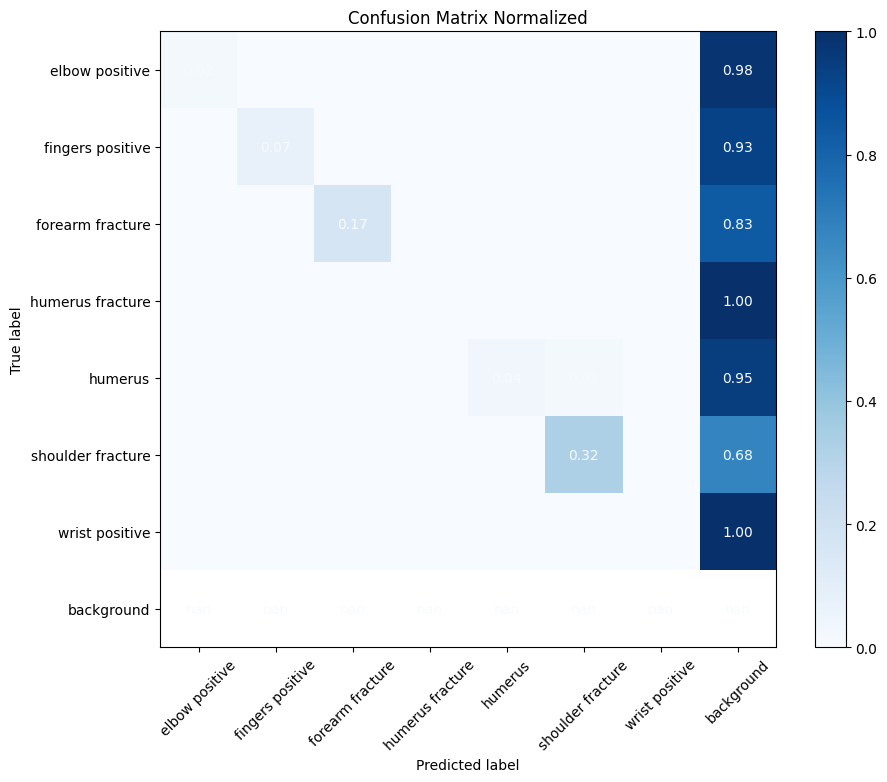

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog

# Define class names (adjust order if your label mapping differs)
class_names = [
    "elbow positive", "fingers positive", "forearm fracture",
    "humerus fracture", "humerus", "shoulder fracture", "wrist positive"
]

# Initialize label collectors
y_true = []
y_pred = []

# Loop through validation data
val_dataset = DatasetCatalog.get("fracture_val")
for item in val_dataset:
    img = cv2.imread(item["file_name"])
    true_classes = [ann["category_id"] for ann in item["annotations"]]

    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.cpu().numpy().tolist() if len(outputs["instances"]) > 0 else []

    # Ensure prediction length matches ground truth
    if len(pred_classes) >= len(true_classes):
        y_pred.extend(pred_classes[:len(true_classes)])
    else:
        # Pad with background class if fewer predictions than annotations
        y_pred.extend(pred_classes + [len(class_names)] * (len(true_classes) - len(pred_classes)))

    y_true.extend(true_classes)


# Pad class names with "background" for confusion matrix (8 classes total)
class_names_with_bg = class_names + ["background"]

# Replace invalid label with background index
y_true_clipped = [c if c < len(class_names) else len(class_names) for c in y_true]
y_pred_clipped = [c if c < len(class_names) else len(class_names) for c in y_pred]

# Compute and plot normalized confusion matrix
cm = confusion_matrix(y_true_clipped, y_pred_clipped, labels=range(len(class_names_with_bg)))
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names_with_bg)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax, values_format=".2f")
plt.title("Confusion Matrix Normalized")
plt.xticks(rotation=45)
plt.show()

WARNING [04/12 17:44:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/12 17:44:35 d2.data.datasets.coco]: Loaded 727 images in COCO format from /content/drive/MyDrive/BoneFractureDetection/processed_data/annotations_remapped/valid_resized_remapped.json


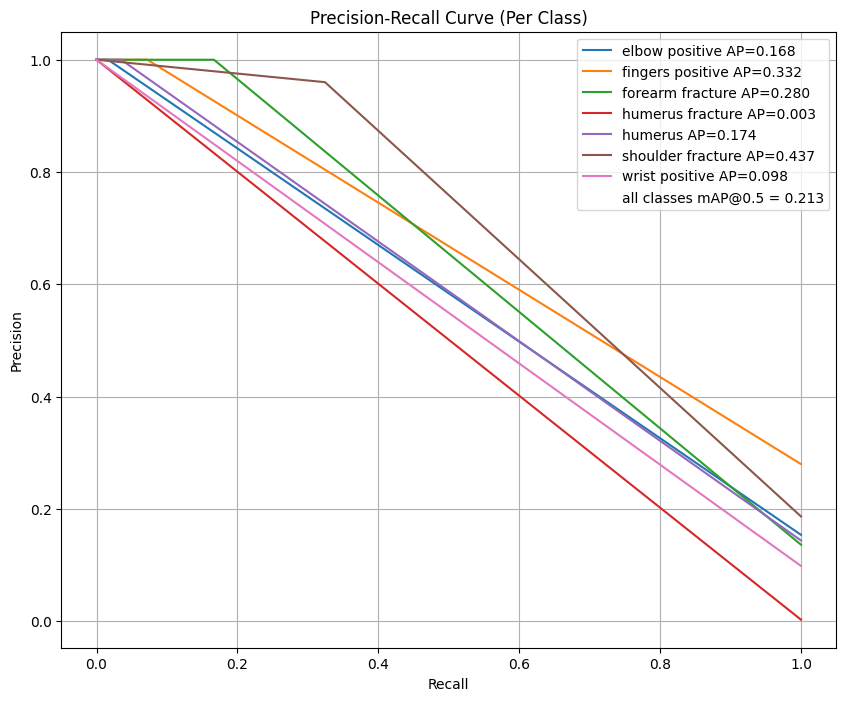

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog

# Class names from your dataset
class_names = [
    "elbow positive", "fingers positive", "forearm fracture",
    "humerus fracture", "humerus", "shoulder fracture", "wrist positive"
]
background_class_id = len(class_names)

# Containers
y_true_clipped = []
y_pred_clipped = []
y_true_bin = []
y_scores_bin = []

val_dataset = DatasetCatalog.get("fracture_val")

for item in val_dataset:
    img = cv2.imread(item["file_name"])
    true_classes = [ann["category_id"] for ann in item["annotations"]]

    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.cpu().numpy().tolist() if len(outputs["instances"]) > 0 else []

    # Match prediction count to ground truth
    if len(pred_classes) >= len(true_classes):
        pred_matched = pred_classes[:len(true_classes)]
    else:
        pred_matched = pred_classes + [background_class_id] * (len(true_classes) - len(pred_classes))

    for t, p in zip(true_classes, pred_matched):
        # Clip both for confusion matrix
        y_true_clipped.append(t if t < background_class_id else background_class_id)
        y_pred_clipped.append(p if p < background_class_id else background_class_id)

        # Binary label for PR curve
        bin_true = [0] * background_class_id
        bin_pred = [0] * background_class_id
        if t < background_class_id:
            bin_true[t] = 1
        if p < background_class_id:
            bin_pred[p] = 1
        y_true_bin.append(bin_true)
        y_scores_bin.append(bin_pred)

# Convert to arrays
y_true_bin = np.array(y_true_bin)
y_scores_bin = np.array(y_scores_bin)

plt.figure(figsize=(10, 8))
aps = []
for i in range(background_class_id):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores_bin[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_scores_bin[:, i])
    aps.append(ap)
    plt.plot(recall, precision, label=f"{class_names[i]} AP={ap:.3f}")

# Mean AP across all classes
mean_ap = np.mean(aps)
plt.plot([], [], ' ', label=f"all classes mAP@0.5 = {mean_ap:.3f}", linewidth=3, color="blue")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Per Class)")
plt.legend()
plt.grid(True)
plt.show()